In [1]:
!pip install openpyxl transformers scikit-learn joblib matplotlib

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for transformers from https://files.pythonhosted.org/packages/d9/b7/98f821d70102e2d38483bbb7013a689d2d646daa4495377bc910374ad727/transformers-4.41.2-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/43.8 kB ? eta -:--:--
     ----------------- -------------------- 20.5/43.8 kB 330.3 kB/s eta 0:00:01
     -------------------------- ----------- 30.7/43.8 kB 435.7 kB/s eta 0:00:01
     -------------------------------------- 43.8/43.8 kB 357.2 kB/s eta 0:00:00
  Obtaining dependency information for huggingface-hub<1.0,>=0.23.0 from https://files.pythonhosted.org/packages/66/e8/bbbad5c7b49c68def42830f96c606e693bfa935a886740a363f04cb84e44/huggingface_hub-0.23.3-py3-none-any.whl.metadata
  Obtaining dependency information for tokenizers<0.20,>=0.19 from https://files.pythonhosted.org/packages/65/8e/6d7d72b28f22c422cff8beae10ac3c2e4376b9be721ef8167b7eecd1da

DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import re
import joblib
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [3]:
# Data Preprocessing
def read_data(train_file, test_file, val_file, train_samples=50000, test_samples=30000, val_samples=5000):
    train_df = pd.read_excel(train_file)
    test_df = pd.read_excel(test_file)
    val_df = pd.read_excel(val_file)

    train_df = train_df.sample(n=train_samples, random_state=42)
    test_df = test_df.sample(n=test_samples, random_state=42)
    val_df = val_df.sample(n=val_samples, random_state=42)

    return train_df, test_df, val_df



In [4]:
def clean_sentence(sent):
    if isinstance(sent, str):
        sent = re.sub('[?.`*^()!°¢܌Ͱ̰ߒנ~×Ҡߘ:ҰߑÍ|।;!,&%\'@#$><A-Za-z0+-9=./''""_০-৯]', '', sent)
        sent = re.sub(r'(\W)(?=\1)', '', sent)
        sent = re.sub(r'https?:\/\/.*[\r\n]*', '', sent, flags=re.MULTILINE)
        sent = re.sub(r'\<a href', ' ', sent)
        sent = re.sub(r'&amp;', '', sent)
        sent = re.sub(r'<br />', ' ', sent)
        sent = re.sub(r'\'', ' ', sent)
        sent = re.sub(r'ߑͰߑ̰ߒנ', '', sent)
        sent = re.sub(r'ߎɰߎɰߎɍ', '', sent)
        sent = re.sub(r'[a-zA-Z]', '', sent)
        sent = re.sub(r'[^\u0980-\u09FF\s]', '', sent)
        sent = re.sub(r'\s+', ' ', sent)
        sent = sent.strip()
        return sent
    else:
        return ''

In [5]:
def remove_stop_words(text):
    stop_words = {'এ', 'হয়', 'কি', 'কী', 'এর', 'কে', 'যে', 'এই', 'বা', 'সব', 'টি', 'তা',
                  'সে', 'তাই', 'সেই', 'তার', 'আগে', 'যদি', 'আছে', 'আমি', 'এবং', 'করে', 'কার', 'এটি', 'হতে', 'যায়',
                  'আরও', 'যাক', 'খুব', 'উপর', 'পরে', 'হবে', 'কেন', 'কখন', 'সকল', 'হয়', 'ঠিক', 'একই', 'কোন',
                  'ছিল', 'খুবই', 'কোনো', 'অধীন', 'যারা', 'তারা', 'গুলি', 'তাকে', 'সেটা', 'সময়', 'আমার', 'আমরা', 'সবার',
                  'উভয়', 'একটা', 'আপনি', 'নিয়ে', 'একটি', 'বন্ধ', 'জন্য', 'শুধু', 'যেটা', 'উচিত', 'মাঝে', 'থেকে', 'করবে',
                  'আবার', 'উপরে', 'সেটি', 'কিছু', 'কারণ', 'যেমন', 'তিনি', 'মধ্যে', 'আমাকে', 'করছেন', 'তুলনা', 'তারপর',
                  'নিজেই', 'থাকার', 'নিজের', 'পারেন', 'একবার', 'সঙ্গে', 'ইচ্ছা', 'নীচের', 'এগুলো', 'আপনার', 'অধীনে', 'কিংবা',
                  'এখানে', 'তাহলে', 'কয়েক', 'জন্যে', 'হচ্ছে', 'তাদের', 'কোথায়', 'কিন্তু', 'নিজেকে', 'যতক্ষণ', 'আমাদের',
                  'দ্বারা', 'হয়েছে', ' সঙ্গে', 'সেখানে', 'কিভাবে', 'মাধ্যমে', 'নিজেদের', 'তুলনায়', 'প্রতিটি',
                  'তাদেরকে', 'ইত্যাদি', 'সম্পর্কে', 'সর্বাধিক', 'বিরুদ্ধে', 'অন্যান্য'}
    text = [w for w in text.split() if not w in stop_words]
    text = ' '.join(text)
    return text


In [6]:
def convert_rating_to_label(rating):
    if rating > 3:
        return 2  # Positive
    elif rating == 3:
        return 1  # Neutral
    else:
        return 0  # Negative

In [7]:
train_file = "train.xlsx"
test_file = "test.xlsx"
val_file = "validation.xlsx"
train_df, test_df, val_df = read_data(train_file, test_file, val_file)

In [8]:
train_df.head()

,id,Book_Name,Writer_Name,Category,Rating,Review,Site,sentiment,label
38777,17345,ইনসাইড ইসলাম (পেপারব্যাক) সত্য ও শান্তির পথে,আব্দুল হাই মুহাম্মদ সাইফুল্লাহ,ইসলামি বই: আত্ম-উন্নয়ন,5,সেরা,Rokomari,positive,2
186,19658,নেভার স্টপ লার্নিং (হার্ডকভার),আয়মান সাদিক,ছাত্রজীবন উন্নয়ন,5,বইটির প্রথম প্রকাশকালে কিনি নাই। কিন্তু পরে যখ...,Rokomari,positive,2
74687,149287,মাতাল হাওয়া (হার্ডকভার) ১৯৬৯ সালে দেখা লেখকে...,হুমায়ূন আহমেদ,সমকালীন উপন্যাস,5,সুন্দর বই,Rokomari,positive,2
76937,67482,অর্থনীতি-দ্বিতীয় পত্র(একাদশ-দ্বাদশ শ্রেণি)(সা...,ড. মোঃ দিদারুল জামাল,উচ্চ মাধ্যমিক অর্থনীতি,5,"অনেক খুজেছি বইটি পাই নি, অবশেষে রকমারি তে পেলা...",Rokomari,positive,2
67601,102329,রুবাইয়াৎ-ই-মির্জা গালিব (হার্ডকভার),মির্জা গালিব,অনুবাদ কবিতা,5,অনুবাদটি স্বরবৃত্ত ছন্দে করা হয়েছে। অনুবাদক অন...,Rokomari,positive,2


In [9]:
train_df['clean_review'] = train_df['Review'].apply(clean_sentence)
test_df['clean_review'] = test_df['Review'].apply(clean_sentence)
val_df['clean_review'] = val_df['Review'].apply(clean_sentence)

In [10]:
train_df.head()

,id,Book_Name,Writer_Name,Category,Rating,Review,Site,sentiment,label,clean_review
38777,17345,ইনসাইড ইসলাম (পেপারব্যাক) সত্য ও শান্তির পথে,আব্দুল হাই মুহাম্মদ সাইফুল্লাহ,ইসলামি বই: আত্ম-উন্নয়ন,5,সেরা,Rokomari,positive,2,সেরা
186,19658,নেভার স্টপ লার্নিং (হার্ডকভার),আয়মান সাদিক,ছাত্রজীবন উন্নয়ন,5,বইটির প্রথম প্রকাশকালে কিনি নাই। কিন্তু পরে যখ...,Rokomari,positive,2,বইটির প্রথম প্রকাশকালে কিনি নাই কিন্তু পরে যখন...
74687,149287,মাতাল হাওয়া (হার্ডকভার) ১৯৬৯ সালে দেখা লেখকে...,হুমায়ূন আহমেদ,সমকালীন উপন্যাস,5,সুন্দর বই,Rokomari,positive,2,সুন্দর বই
76937,67482,অর্থনীতি-দ্বিতীয় পত্র(একাদশ-দ্বাদশ শ্রেণি)(সা...,ড. মোঃ দিদারুল জামাল,উচ্চ মাধ্যমিক অর্থনীতি,5,"অনেক খুজেছি বইটি পাই নি, অবশেষে রকমারি তে পেলা...",Rokomari,positive,2,অনেক খুজেছি বইটি পাই নি অবশেষে রকমারি তে পেলাম...
67601,102329,রুবাইয়াৎ-ই-মির্জা গালিব (হার্ডকভার),মির্জা গালিব,অনুবাদ কবিতা,5,অনুবাদটি স্বরবৃত্ত ছন্দে করা হয়েছে। অনুবাদক অন...,Rokomari,positive,2,অনুবাদটি স্বরবৃত্ত ছন্দে করা হয়েছে অনুবাদক অনে...


In [11]:
train_df['clean_review'] = train_df['clean_review'].apply(remove_stop_words)
test_df['clean_review'] = test_df['clean_review'].apply(remove_stop_words)
val_df['clean_review'] = val_df['clean_review'].apply(remove_stop_words)

In [12]:
train_df.head()

,id,Book_Name,Writer_Name,Category,Rating,Review,Site,sentiment,label,clean_review
38777,17345,ইনসাইড ইসলাম (পেপারব্যাক) সত্য ও শান্তির পথে,আব্দুল হাই মুহাম্মদ সাইফুল্লাহ,ইসলামি বই: আত্ম-উন্নয়ন,5,সেরা,Rokomari,positive,2,সেরা
186,19658,নেভার স্টপ লার্নিং (হার্ডকভার),আয়মান সাদিক,ছাত্রজীবন উন্নয়ন,5,বইটির প্রথম প্রকাশকালে কিনি নাই। কিন্তু পরে যখ...,Rokomari,positive,2,বইটির প্রথম প্রকাশকালে কিনি নাই যখন কিনলাম তখন...
74687,149287,মাতাল হাওয়া (হার্ডকভার) ১৯৬৯ সালে দেখা লেখকে...,হুমায়ূন আহমেদ,সমকালীন উপন্যাস,5,সুন্দর বই,Rokomari,positive,2,সুন্দর বই
76937,67482,অর্থনীতি-দ্বিতীয় পত্র(একাদশ-দ্বাদশ শ্রেণি)(সা...,ড. মোঃ দিদারুল জামাল,উচ্চ মাধ্যমিক অর্থনীতি,5,"অনেক খুজেছি বইটি পাই নি, অবশেষে রকমারি তে পেলা...",Rokomari,positive,2,অনেক খুজেছি বইটি পাই নি অবশেষে রকমারি তে পেলাম...
67601,102329,রুবাইয়াৎ-ই-মির্জা গালিব (হার্ডকভার),মির্জা গালিব,অনুবাদ কবিতা,5,অনুবাদটি স্বরবৃত্ত ছন্দে করা হয়েছে। অনুবাদক অন...,Rokomari,positive,2,অনুবাদটি স্বরবৃত্ত ছন্দে করা হয়েছে অনুবাদক অনে...


In [13]:
train_df['label'] = train_df['Rating'].apply(convert_rating_to_label)
test_df['label'] = test_df['Rating'].apply(convert_rating_to_label)
val_df['label'] = val_df['Rating'].apply(convert_rating_to_label)


In [14]:
train_df.head()

,id,Book_Name,Writer_Name,Category,Rating,Review,Site,sentiment,label,clean_review
38777,17345,ইনসাইড ইসলাম (পেপারব্যাক) সত্য ও শান্তির পথে,আব্দুল হাই মুহাম্মদ সাইফুল্লাহ,ইসলামি বই: আত্ম-উন্নয়ন,5,সেরা,Rokomari,positive,2,সেরা
186,19658,নেভার স্টপ লার্নিং (হার্ডকভার),আয়মান সাদিক,ছাত্রজীবন উন্নয়ন,5,বইটির প্রথম প্রকাশকালে কিনি নাই। কিন্তু পরে যখ...,Rokomari,positive,2,বইটির প্রথম প্রকাশকালে কিনি নাই যখন কিনলাম তখন...
74687,149287,মাতাল হাওয়া (হার্ডকভার) ১৯৬৯ সালে দেখা লেখকে...,হুমায়ূন আহমেদ,সমকালীন উপন্যাস,5,সুন্দর বই,Rokomari,positive,2,সুন্দর বই
76937,67482,অর্থনীতি-দ্বিতীয় পত্র(একাদশ-দ্বাদশ শ্রেণি)(সা...,ড. মোঃ দিদারুল জামাল,উচ্চ মাধ্যমিক অর্থনীতি,5,"অনেক খুজেছি বইটি পাই নি, অবশেষে রকমারি তে পেলা...",Rokomari,positive,2,অনেক খুজেছি বইটি পাই নি অবশেষে রকমারি তে পেলাম...
67601,102329,রুবাইয়াৎ-ই-মির্জা গালিব (হার্ডকভার),মির্জা গালিব,অনুবাদ কবিতা,5,অনুবাদটি স্বরবৃত্ত ছন্দে করা হয়েছে। অনুবাদক অন...,Rokomari,positive,2,অনুবাদটি স্বরবৃত্ত ছন্দে করা হয়েছে অনুবাদক অনে...


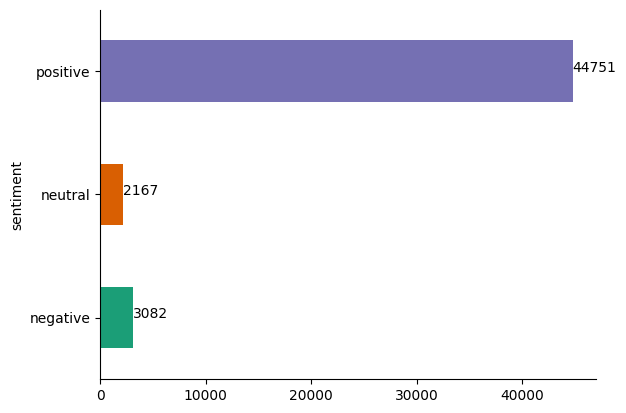

In [15]:
# @title sentiment

from matplotlib import pyplot as plt
import seaborn as sns

# Grouping by sentiment and getting the size of each group
sentiment_counts = train_df.groupby('sentiment').size()

# Plotting the horizontal bar chart
sentiment_counts.plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))

# Adding annotations to each bar to display its value
for index, value in enumerate(sentiment_counts):
    plt.text(value, index, str(value))

# Removing top and right spines
plt.gca().spines[['top', 'right',]].set_visible(False)

# Displaying the plot
plt.show()


In [16]:
df_selected = pd.concat([train_df, test_df, val_df], axis=0)

In [17]:
df_selected.head()

,id,Book_Name,Writer_Name,Category,Rating,Review,Site,sentiment,label,clean_review
38777,17345,ইনসাইড ইসলাম (পেপারব্যাক) সত্য ও শান্তির পথে,আব্দুল হাই মুহাম্মদ সাইফুল্লাহ,ইসলামি বই: আত্ম-উন্নয়ন,5,সেরা,Rokomari,positive,2,সেরা
186,19658,নেভার স্টপ লার্নিং (হার্ডকভার),আয়মান সাদিক,ছাত্রজীবন উন্নয়ন,5,বইটির প্রথম প্রকাশকালে কিনি নাই। কিন্তু পরে যখ...,Rokomari,positive,2,বইটির প্রথম প্রকাশকালে কিনি নাই যখন কিনলাম তখন...
74687,149287,মাতাল হাওয়া (হার্ডকভার) ১৯৬৯ সালে দেখা লেখকে...,হুমায়ূন আহমেদ,সমকালীন উপন্যাস,5,সুন্দর বই,Rokomari,positive,2,সুন্দর বই
76937,67482,অর্থনীতি-দ্বিতীয় পত্র(একাদশ-দ্বাদশ শ্রেণি)(সা...,ড. মোঃ দিদারুল জামাল,উচ্চ মাধ্যমিক অর্থনীতি,5,"অনেক খুজেছি বইটি পাই নি, অবশেষে রকমারি তে পেলা...",Rokomari,positive,2,অনেক খুজেছি বইটি পাই নি অবশেষে রকমারি তে পেলাম...
67601,102329,রুবাইয়াৎ-ই-মির্জা গালিব (হার্ডকভার),মির্জা গালিব,অনুবাদ কবিতা,5,অনুবাদটি স্বরবৃত্ত ছন্দে করা হয়েছে। অনুবাদক অন...,Rokomari,positive,2,অনুবাদটি স্বরবৃত্ত ছন্দে করা হয়েছে অনুবাদক অনে...


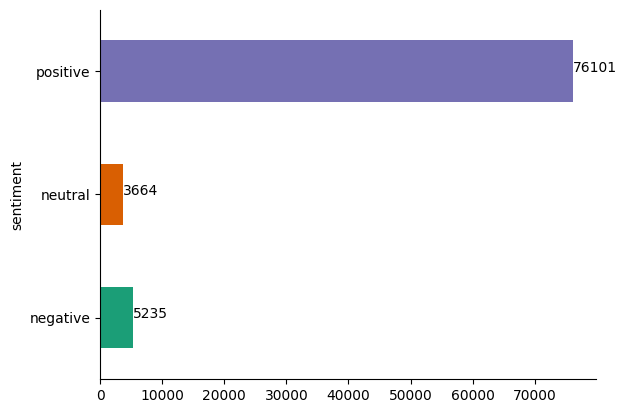

In [18]:
# Grouping by sentiment and getting the size of each group
sentiment_counts = df_selected.groupby('sentiment').size()

# Plotting the horizontal bar chart
sentiment_counts.plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))

# Adding annotations to each bar to display its value
for index, value in enumerate(sentiment_counts):
    plt.text(value, index, str(value))

# Removing top and right spines
plt.gca().spines[['top', 'right',]].set_visible(False)

# Displaying the plot
plt.show()


In [19]:
X = df_selected['clean_review']
y = df_selected['label']


In [20]:
X.head()

38777                                                 সেরা
186      বইটির প্রথম প্রকাশকালে কিনি নাই যখন কিনলাম তখন...
74687                                            সুন্দর বই
76937    অনেক খুজেছি বইটি পাই নি অবশেষে রকমারি তে পেলাম...
67601    অনুবাদটি স্বরবৃত্ত ছন্দে করা হয়েছে অনুবাদক অনে...
Name: clean_review, dtype: object

In [21]:
y.head()

38777    2
186      2
74687    2
76937    2
67601    2
Name: label, dtype: int64

In [22]:
X_text = df_selected[df_selected['clean_review'].apply(lambda x: isinstance(x, str))]['clean_review']
y_filtered = df_selected[df_selected['clean_review'].apply(lambda x: isinstance(x, str))]['label']


In [23]:
X_text.head()

38777                                                 সেরা
186      বইটির প্রথম প্রকাশকালে কিনি নাই যখন কিনলাম তখন...
74687                                            সুন্দর বই
76937    অনেক খুজেছি বইটি পাই নি অবশেষে রকমারি তে পেলাম...
67601    অনুবাদটি স্বরবৃত্ত ছন্দে করা হয়েছে অনুবাদক অনে...
Name: clean_review, dtype: object

In [24]:
y_filtered.head()

38777    2
186      2
74687    2
76937    2
67601    2
Name: label, dtype: int64

In [25]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X_text)

In [44]:
X_tfidf 

<85000x12084 sparse matrix of type '<class 'numpy.float64'>'
	with 767095 stored elements in Compressed Sparse Row format>

In [26]:
X_train, X_temp, y_train, y_temp = train_test_split(X_tfidf, y_filtered, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [27]:
X_train

<51000x12084 sparse matrix of type '<class 'numpy.float64'>'
	with 459685 stored elements in Compressed Sparse Row format>

In [28]:
y_train

60097    2
98330    2
16888    2
89759    2
10872    2
        ..
14247    2
28198    1
11515    2
69116    2
52461    2
Name: label, Length: 51000, dtype: int64

In [29]:
X_test

<17000x12084 sparse matrix of type '<class 'numpy.float64'>'
	with 153259 stored elements in Compressed Sparse Row format>

In [30]:
y_test

39554     2
28355     2
8476      2
11843     2
102462    2
         ..
1955      2
6148      2
19948     2
22476     2
22332     2
Name: label, Length: 17000, dtype: int64

In [31]:
# Train Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [32]:
# Train SVM model
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [33]:
# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [34]:
models = {
    "lr": lr_model,
    "svm": svm_model,
    "rf": rf_model
}

In [35]:
def evaluate_model(model, X_train, X_test, X_val, y_train, y_test, y_val):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_pred_val = model.predict(X_val)

    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    val_accuracy = accuracy_score(y_val, y_pred_val)

    precision = precision_score(y_test, y_pred_test, average='weighted')
    recall = recall_score(y_test, y_pred_test, average='weighted')
    f1 = f1_score(y_test, y_pred_test, average='weighted')

    return train_accuracy, test_accuracy, val_accuracy, precision, recall, f1

In [36]:
# Evaluate Logistic Regression model
lr_scores = evaluate_model(lr_model, X_train, X_test, X_val, y_train, y_test, y_val)
print(f"Logistic Regression - Train Accuracy: {lr_scores[0]}, Test Accuracy: {lr_scores[1]}, Validation Accuracy: {lr_scores[2]}, Precision: {lr_scores[3]}, Recall: {lr_scores[4]}, F1 Score: {lr_scores[5]}")


Logistic Regression - Train Accuracy: 0.9042941176470588, Test Accuracy: 0.9004117647058824, Validation Accuracy: 0.9033529411764706, Precision: 0.87153965622557, Recall: 0.9004117647058824, F1 Score: 0.8632321028557016


In [37]:

# Evaluate SVM model
svm_scores = evaluate_model(svm_model, X_train, X_test, X_val, y_train, y_test, y_val)
print(f"SVM - Train Accuracy: {svm_scores[0]}, Test Accuracy: {svm_scores[1]}, Validation Accuracy: {svm_scores[2]}, Precision: {svm_scores[3]}, Recall: {svm_scores[4]}, F1 Score: {svm_scores[5]}")


SVM - Train Accuracy: 0.9010588235294118, Test Accuracy: 0.8981764705882352, Validation Accuracy: 0.9001764705882352, Precision: 0.8764818190252207, Recall: 0.8981764705882352, F1 Score: 0.8545328548237813


In [38]:
# Evaluate Random Forest model
rf_scores = evaluate_model(rf_model, X_train, X_test, X_val, y_train, y_test, y_val)
print(f"Random Forest - Train Accuracy: {rf_scores[0]}, Test Accuracy: {rf_scores[1]}, Validation Accuracy: {rf_scores[2]}, Precision: {rf_scores[3]}, Recall: {rf_scores[4]}, F1 Score: {rf_scores[5]}")

Random Forest - Train Accuracy: 0.967764705882353, Test Accuracy: 0.907235294117647, Validation Accuracy: 0.9118235294117647, Precision: 0.8916515993477878, Recall: 0.907235294117647, F1 Score: 0.879422784036613


In [39]:
joblib.dump(lr_model, 'lr_model.pkl')
joblib.dump(svm_model, 'svm_model.pkl')
joblib.dump(rf_model, 'rf_model.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

In [40]:
model_names = ['Logistic Regression', 'SVM', 'Random Forest']
train_accuracies = [lr_scores[0], svm_scores[0], rf_scores[0]]
test_accuracies = [lr_scores[1], svm_scores[1], rf_scores[1]]
val_accuracies = [lr_scores[2], svm_scores[2], rf_scores[2]]

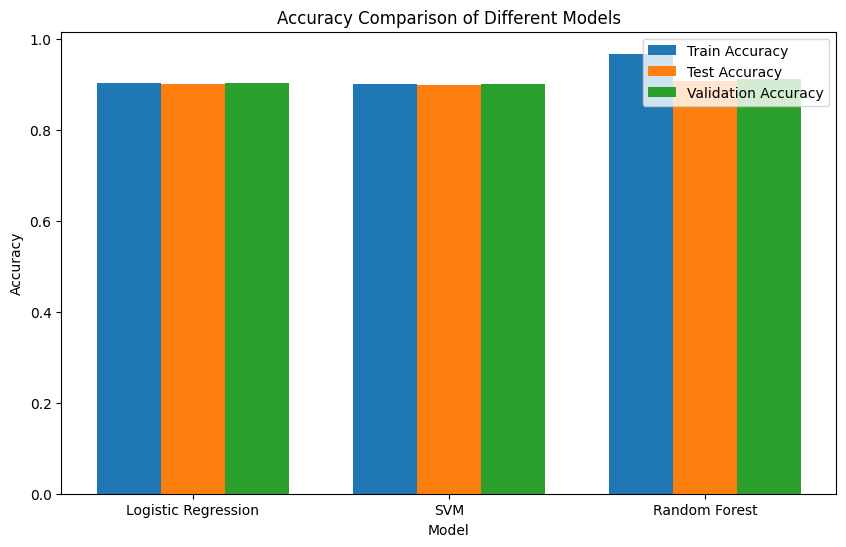

In [41]:
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.25
index = np.arange(len(model_names))
bar1 = plt.bar(index, train_accuracies, bar_width, label='Train Accuracy')
bar2 = plt.bar(index + bar_width, test_accuracies, bar_width, label='Test Accuracy')
bar3 = plt.bar(index + 2 * bar_width, val_accuracies, bar_width, label='Validation Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Models')
plt.xticks(index + bar_width, model_names)
plt.legend()

plt.show()

In [42]:
def predict_aspect_sentiment(sentence, models, vectorizer):
    cleaned_sentence = clean_sentence(sentence)
    aspects = ["বই", "লেখা", "গল্প", "কাহিনী", "লেখক"]
    sentiment_mapping = {0: "negative", 1: "neutral", 2: "positive"}

    aspect_sentiment = {}
    for aspect in aspects:
        if aspect in cleaned_sentence:
            aspect_cleaned_sentence = clean_sentence(sentence.replace(aspect, ""))
            aspect_vectorized = vectorizer.transform([aspect_cleaned_sentence])

            lr_prediction = models['lr'].predict(aspect_vectorized)[0]
            svm_prediction = models['svm'].predict(aspect_vectorized)[0]
            rf_prediction = models['rf'].predict(aspect_vectorized)[0]

            aspect_sentiment[aspect] = {
                "lr": sentiment_mapping[lr_prediction],
                "svm": sentiment_mapping[svm_prediction],
                "rf": sentiment_mapping[rf_prediction]
            }

    return aspect_sentiment

In [43]:
# Example Sentences and Actual Sentiments
example_sentences = [
    "আমার পছন্দের লেখক, তার এই বই টা ভাল লাগল",  # Positive about লেখক, Positive about বই
    "গল্প টি ফালতু",  # Negative about গল্প
    "কাহিনী ভাল ",  # Positive about কাহিনী
    "বই টি ফালতু",  # Negative about বই
    "লেখকের লিখার ধরণ চমৎকার, গল্পের মোচড় দারুন",  # Positive about লেখক, Positive about গল্প
]

predicted_sentiments = [predict_aspect_sentiment(sentence, models, tfidf_vectorizer) for sentence in example_sentences]

for i, (sentence, predictions) in enumerate(zip(example_sentences, predicted_sentiments)):
    print(f"Sentence: {sentence}")
    for aspect, preds in predictions.items():
        print(f"Aspect: {aspect}")
        print(f"  Logistic Regression Prediction: {preds['lr']}")
        print(f"  SVM Prediction: {preds['svm']}")
        print(f"  Random Forest Prediction: {preds['rf']}")
    print("\n")

Sentence: আমার পছন্দের লেখক, তার এই বই টা ভাল লাগল
Aspect: বই
  Logistic Regression Prediction: positive
  SVM Prediction: positive
  Random Forest Prediction: positive
Aspect: লেখক
  Logistic Regression Prediction: positive
  SVM Prediction: positive
  Random Forest Prediction: positive


Sentence: গল্প টি ফালতু
Aspect: গল্প
  Logistic Regression Prediction: negative
  SVM Prediction: negative
  Random Forest Prediction: negative


Sentence: কাহিনী ভাল 
Aspect: কাহিনী
  Logistic Regression Prediction: positive
  SVM Prediction: positive
  Random Forest Prediction: positive


Sentence: বই টি ফালতু
Aspect: বই
  Logistic Regression Prediction: negative
  SVM Prediction: negative
  Random Forest Prediction: negative


Sentence: লেখকের লিখার ধরণ চমৎকার, গল্পের মোচড় দারুন
Aspect: গল্প
  Logistic Regression Prediction: positive
  SVM Prediction: positive
  Random Forest Prediction: positive
Aspect: লেখক
  Logistic Regression Prediction: positive
  SVM Prediction: positive
  Random Forest Pre